In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
w = 21.48e-3 #meters
t = 3.18e-3 #meters
l = 103.18e-3 #meters

In [9]:
# converts inches to meters
def to_m(inches):
    return inches*0.0254

# converts pounds to kilograms
def to_kg(pounds):
    return pounds*0.453592

# converts pounds per square inch to pascals
def to_pa(psi):
    return psi*6894.757

In [369]:
# support dimensions as modeled in solidworks
L = to_m(4) # height of support, in m
w1 = to_m(0.483513) # width of the support bases, in m
w2 = to_m(0.88) # width of the support cross-sectional area at the center, in m
t_in = [1/8., 3/16., 1/4., 3/8., 1/2.] # G10 thicknesses available from McMaster Carr
t = [to_m(t) for t in t_in]
# material properties of G10
E = to_pa(1.74e6) # modulus of elasticity, in pascals
yield_strength = to_pa(9430) # yield strength, in pascals
vacuum_load = to_kg(71)*9.8
load_40k = to_kg(38)*9.8

In [3]:
# moment of inertia of a rectangle
def moment_of_inertia(w, t):
#     print(np.power(t, 3))
#     print('Width: ', w)
    I = w*np.power(t, 3)/12.
    return I

In [14]:
critical_load(to_pa(1.74e6), l, w, t)/9.8

65.32587360455553

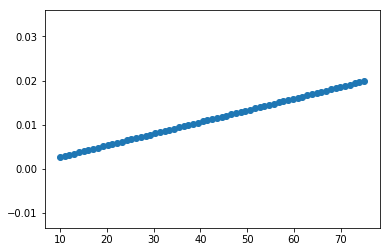

In [10]:
moment_of_inertia(w, l)
weights = np.linspace(10, 75, 65)
deflections = []
for i in weights:
    deflections.append(deflection(i, l, w, t, to_pa(1.74e6)))
plt.scatter(weights, deflections)

In [6]:
# calculates the deflection
def deflection(weight, l, w, t, E):
#     print('Weight: ', weight)
#     print('Length: ', l)
#     print('Width: ', w)
#     print('Thickness: ', t)
#     print('E: ', E)
    I = moment_of_inertia(w, t)*2.
#     print('I: ', I)
    d = weight*np.power(l, 3)/(3*E*I)
#     print('Deflection: ', d)
    return d

Text(0.5, 1.0, 'Lateral Deflection of G10 Supports')

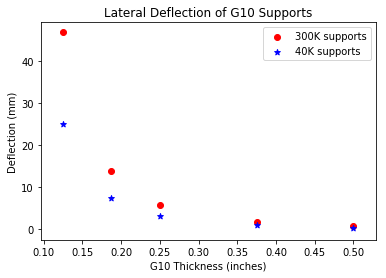

In [372]:
deflection_data = pd.DataFrame(columns=['G10 Thickness (inches)', '300K Deflection (mm)', '40K Deflection (mm)'])
deflections_vac = []
deflections_40k = []
t_mm = []
for i in t:
    t_mm.append(i*1000)
    d_vac = deflection(vacuum_load, L, w1, i, E)
    deflections_vac.append(d_vac*1000/3.)
    d_40k = deflection(load_40k, L, w1, i, E)
    deflections_40k.append(d_40k*1000/3.)
deflection_data['G10 Thickness (inches)'] = t_in
deflection_data['300K Deflection (mm)'] = deflections_vac
deflection_data['40K Deflection (mm)'] = deflections_40k
deflection_data.set_index('G10 Thickness (inches)')
plt.scatter(t_in, deflections_vac, marker='o', color='red', label='300K supports')
plt.scatter(t_in, deflections_40k, marker='*', color='blue', label='40K supports')
plt.xlabel("G10 Thickness (inches)")
plt.ylabel("Deflection (mm)")
plt.legend()
plt.title('Lateral Deflection of G10 Supports')
# plt.savefig('C:\\Users\jemoor15\Desktop\LateralDeflection.pdf')

In [11]:
# critical load for a column of dimensions w/t/L and modulus of elasticity E
def critical_load(E, L, w, t):
    I = moment_of_inertia(w, t)
    p_cr = (np.pi**2) * E * I /(L**2)
    return p_cr

Text(0.5, 1.0, 'Critical and Allowable Loads - Factor of Safety = 10')

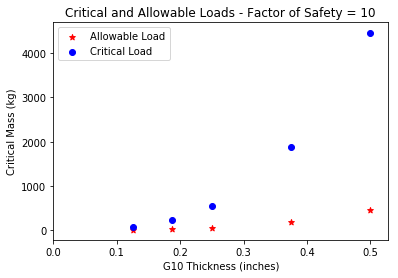

In [377]:
critical_loads = []
allowable_loads = []
pcr_data = pd.DataFrame(columns = ['G10 Thickness (inches)', 'Critical Load (kg)', 'Allowable Load (kg)'])
for i in t:
    critical_loads.append(critical_load(E, L, w2, i)/9.8)
    allowable_loads.append(critical_load(E, L, w2, i)/(10*9.8))
pcr_data['G10 Thickness (inches)'] = t_in
pcr_data['Critical Load (kg)'] = critical_loads
pcr_data['Allowable Load (kg)'] = allowable_loads
plt.scatter(t_in, allowable_loads, marker='*', color='red', label='Allowable Load')
plt.scatter(t_in, critical_loads, marker='o', color='blue', label='Critical Load')
plt.xlim(0)
plt.xlabel('G10 Thickness (inches)')
plt.ylabel('Critical Mass (kg)')
plt.legend()
plt.title('Critical and Allowable Loads - Factor of Safety = 10')

In [378]:
# maximum bending moment of an eccentrically loaded column
def max_bending_moment(E, L, w, t, p_tot, ecc):
    I = moment_of_inertia(w, t)
    a = w*t
    r = np.sqrt(I/a)
    p_cr = critical_load(E, L, w, t)
    arg = (np.pi/2.)*np.sqrt(p_tot/p_cr)
    M_max = p_tot*ecc/np.cos(arg)
    return I, a, r, p_cr, M_max

Text(0.5, 1.0, 'Maximum Bending Moments')

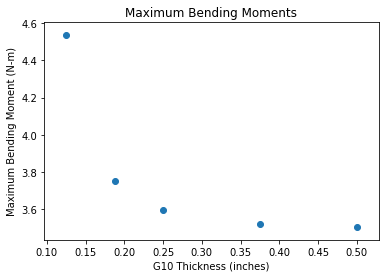

In [390]:
max_bending = []
load = to_kg(30)*9.8
ecc = to_m(1.03)
for i in t:
    max_bending.append(max_bending_moment(E, L, w2, i, load, ecc)[-1])
plt.scatter(t_in, max_bending)
plt.xlabel('G10 Thickness (inches)')
plt.ylabel('Maximum Bending Moment (N-m)')
plt.title('Maximum Bending Moments')

In [216]:
len(t_in), len(t)

(8, 8)

In [391]:
# maximum compressive stress experienced by the column for a load p_tot at a given distance from the center of the cross-section ecc
def max_compressive_stress(E, L, w, t, p_tot, ecc):
    I, a, r, p_cr, M_max = max_bending_moment(E, L, w, t, p_tot, ecc)
    c = t/2.
    sigma_max = p_tot/a + M_max*c/I
    return sigma_max, p_cr/a

Text(0.5, 1.0, 'Maximum Compressive Stresses')

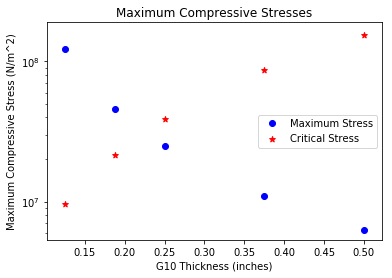

In [392]:
max_comp_stress = []
critical_comp_stress = []
load = to_kg(30)*9.8
ecc = to_m(1.03)
for i in t:
    max_comp_stress.append(max_compressive_stress(E, L, w2, i, load, ecc)[0])
    critical_comp_stress.append(max_compressive_stress(E, L, w2, i, load, ecc)[1])
plt.semilogy(t_in, max_comp_stress, marker='o', lw=0, color='blue', label='Maximum Stress')
plt.scatter(t_in, critical_comp_stress, marker='*', color='red', label='Critical Stress')
plt.xlabel('G10 Thickness (inches)')
plt.ylabel('Maximum Compressive Stress (N/m^2)')
plt.legend()
plt.title('Maximum Compressive Stresses')

In [221]:
# calculates the factor of safety for a given maximum stress
def factor_of_safety(allowable_stress, maximum_stress):
    return allowable_stress/maximum_stress

In [393]:
# calculate the factor of safety for each thickness
# assumes a 30lb load 1.03in away from the center of the support cross-section
load = to_kg(30)*9.8
max_stresses = []
critical_stresses = []
critical_loads = []
fos = []
for thickness in t:
    maximum_stress, critical_stress = max_compressive_stress(E, L, w, thickness, load, to_m(1.03))
    critical_stresses.append(critical_stress)
    max_stresses.append(maximum_stress)
    critical_loads.append(critical_stress*(w*thickness))
    fos.append(factor_of_safety(yield_strength, maximum_stress))

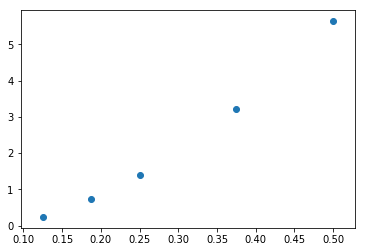

In [394]:
plt.scatter(t_in, fos)

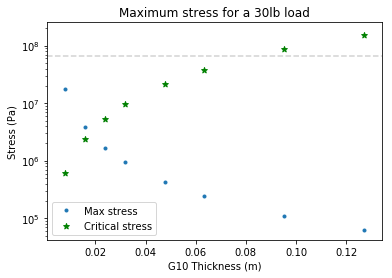

In [133]:
plt.semilogy(t, max_stresses, marker='.', lw=0, label='Max stress')
# for i in t:
#     plt.axvline(i, ls = '--', color='lightgray')
plt.axhline(yield_strength, ls ='--', color='lightgray')
plt.scatter(t, critical_stresses, marker = '*', label='Critical stress', color = 'green')
# plt.scatter(t, sig_yield, marker = 'x', label='Yield stress', color = 'red')
plt.xlabel('G10 Thickness (m)')
plt.ylabel('Stress (Pa)')
plt.title('Maximum stress for a 30lb load')
plt.legend()
# plt.savefig('C:\\Users\jemoor15\Desktop\stress.pdf')

In [293]:
# coefficients of fit equation from NIST
a = -4.1236
b = 13.788
c = -26.068
d = 26.272
e = -14.663
f = 4.4954
g = -0.6905
h = 0.0397
coefficients = [a, b, c, d, e, f, g, h]

In [327]:
# generate the NIST curve fit equation
def thermal_conductivity(temp, coefficients):
    log_k = 0.
    for n in range(len(coefficients)):
        log_k += coefficients[n]*(np.power(np.log10(temp), n))
    return np.power(10, log_k)

In [328]:
temps = np.linspace(1, 400, 400)
ks = []
for temp in temps:
    ks.append(thermal_conductivity(temp, coefficients))

In [329]:
width = .01533 # m
length = .13974 # m
gs = []
for i in t:
    g = (w*i/length)
    gs.append(g)

In [330]:
# generates conducted heat per leg of the x
def get_q(ks, t1, t2, g):
    k = np.average(ks[t1-1:t2])
    q = k*(t2-t1)*g
    return q

In [339]:
qs4 = []
for g in gs:
    qs4.append(2* get_q(ks, 4, 40, g))
qs40 = []
for g in gs:
    qs40.append(2*get_q(ks, 40, 300, g))

Text(0.5, 1.0, 'G10 Heat Conduction (Top: 300-40K, Bottom: 40-4K)')

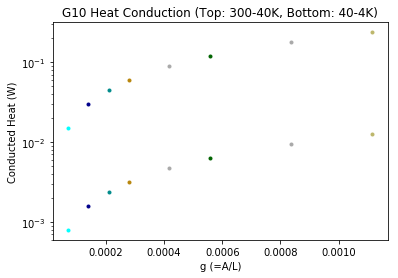

In [340]:
for i in range(len(t)):
    plt.semilogy(gs[i], qs4[i], marker='.', color=list(colors.keys())[i+28])
    plt.semilogy(gs[i], qs40[i], marker='.', color=list(colors.keys())[i+28])
plt.ylabel('Conducted Heat (W)')
plt.xlabel('g (=A/L)')
plt.title('G10 Heat Conduction (Top: 300-40K, Bottom: 40-4K)')

In [302]:
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

In [341]:
heat_data = pd.DataFrame(columns=['G10 Thickness (inches)', 'Heat Conducted 4-40K (W)', 'Heat Conducted 40-300K (W)'])
heat_data['G10 Thickness (inches)'] = t_in
heat_data['Heat Conducted 4-40K (W)'] = qs4
heat_data['Heat Conducted 40-300K (W)'] = qs40

In [342]:
heat_data

,G10 Thickness (inches),Heat Conducted 4-40K (W),Heat Conducted 40-300K (W)
0,0.03125,0.000796,0.014792
1,0.06250,0.001592,0.029584
2,0.09375,0.002388,0.044376
3,0.12500,0.003184,0.059168
4,0.18750,0.004775,0.088752
5,0.25000,0.006367,0.118336
6,0.37500,0.009551,0.177505
7,0.50000,0.012734,0.236673


In [397]:
deflection_data['300K Deflection/span'] = deflection_data['300K Deflection (mm)']/L
deflection_data['40K Deflection/span'] = deflection_data['40K Deflection (mm)']/(L*1000)
deflection_data

,G10 Thickness (inches),300K Deflection (mm),40K Deflection (mm),300K Deflection/span,40K Deflection/span
0,0.1250,46.794887,25.045151,460.579596,0.246507
1,0.1875,13.865152,7.420785,136.468028,0.073039
2,0.2500,5.849361,3.130644,57.572449,0.030813
3,0.3750,1.733144,0.927598,17.058504,0.009130
4,0.5000,0.731170,0.391330,7.196556,0.003852


In [351]:
pcr_data

,G10 Thickness (inches),Critical Load (kg),Allowable Load (kg)
0,0.03125,1.090287,0.109029
1,0.06250,8.722296,0.872230
2,0.09375,29.437748,2.943775
3,0.12500,69.778366,6.977837
4,0.18750,235.501987,23.550199
5,0.25000,558.226932,55.822693
6,0.37500,1884.015894,188.401589
7,0.50000,4465.815452,446.581545


0.0025

In [ ]:
21.48mm x 3.18mm